In [3]:
!curl -O https://static.miglix.eu/data/dataset_BRATS.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.4G  100 12.4G    0     0  19.6M      0  0:10:47  0:10:47 --:--:-- 20.0M


In [10]:
!curl -O https://static.miglix.eu/data/nonres-cp.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  355M  100  355M    0     0  17.3M      0  0:00:20  0:00:20 --:--:-- 20.4M


In [4]:
!rm -rf brats-net
!git clone https://github.com/hesiod/brats-net.git
!rm -f model
!ln -s brats-net/model .

Cloning into 'brats-net'...
remote: Enumerating objects: 303, done.
remote: Counting objects: 100% (303/303), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 303 (delta 191), reused 211 (delta 110), pack-reused 0
Receiving objects: 100% (303/303), 142.65 KiB | 6.79 MiB/s, done.
Resolving deltas: 100% (191/191), done.


In [1]:
import torch
import torch.utils.data as td
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
from tqdm import tqdm, trange
import argparse
import datetime
import json
import jsonschema
import matplotlib.pyplot as plt

In [2]:
import model.brats_dataset
import model.unet
import model.res_unet
import model.utils
import model.metrics
import model.loss

In [34]:
class Context:
    def __init__(self, params, checkpoint_filename=None, criterion=None):
        self.params = params

        if params['model'] == 'UNet':
            self.net = model.unet.Net(params['input_channels'])
        elif params['model'] == 'UResNet':
            self.net = model.res_unet.UResNet(params['input_channels'])
        else:
            print('unknown model "{}"'.format(params['model']))

        self.device = model.utils.try_gpu()
        print('Using device {}'.format(self.device))
        self.net.to(self.device)

        if params['optimizer'] == 'AdamW':
            self.optimizer = torch.optim.AdamW(
                self.net.parameters(),
                lr=self.params['lr'],
                weight_decay=params['adam_weight_decay']
            )
        elif params['optimizer'] == 'SGD':
            self.optimizer = torch.optim.SGD(
                self.net.parameters(),
                lr=self.params['lr'],
                weight_decay=params['sgd_weight_decay'],
                momentum=params['sgd_momentum']
            )
        else:
            print('unknown optimizer "{}"'.format(params['optimizer']))

        if params['scheduler'] == 'ReduceLROnPlateau':
            self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                'min',
                patience=params['lr_scheduler_patience']
            )
        elif params['scheduler'] == 'CosineAnnealingWarmRestarts':
            self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                self.optimizer,
                T_0=params['sgdr_initial_period'],
                T_mult=params['sgdr_period_multiplier']
            )
        else:
            print('unknown scheduler "{}"'.format(params['scheduler']))

        if checkpoint_filename:
            checkpoint = torch.load(checkpoint_filename)
            self.net.load_state_dict(checkpoint['model'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.scheduler.load_state_dict(checkpoint['scheduler'])
            self.global_iter = checkpoint['global_iter']
        else:
            self.net.apply(model.unet.init_weights)
            self.global_iter = 0

        self.model_shape = (1, params['input_channels'], 240, 240)

    def check_topology(self):
        with torch.no_grad():
            dummy_input = torch.empty(size=self.model_shape, dtype=torch.float32).to(self.device)
            y = self.net(dummy_input)

    def export_onnx(self, filename):
        dummy_input = torch.empty(size=self.model_shape).to(self.device)
        torch.onnx.export(self.net, dummy_input, filename, verbose=True)

    def checkpoint_path(self):
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')
        checkpoint_dir = os.path.join(
            'checkpoints',
            self.params['meta_name'],
        )
        checkpoint_path = os.path.join(
            checkpoint_dir,
            'checkpoint_{}.pt'.format(datetime.datetime.now().isoformat())
        )
        if not os.path.exists(checkpoint_dir):
            os.mkdir(checkpoint_dir)
        return checkpoint_path

    def save_checkpoint(self):
        state_dict = {
            'model': self.net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict(),
            'global_iter': self.global_iter,
            }
        torch.save(state_dict, self.checkpoint_path())


In [31]:

class TrainContext:
    def __init__(self, context, dataset, criterion):
        self.ctx = context
        self.criterion = criterion

        ds_size = len(dataset)
        test_count = ds_size // 10
        train_count = ds_size - test_count
        test_indices = torch.arange(start=0, end=test_count)
        train_indices = torch.arange(start=test_count+1, end=ds_size-1)
        self.train_dataset = td.Subset(dataset, indices=train_indices)
        self.test_dataset  = td.Subset(dataset, indices=test_indices)

        log_dir = os.path.join(
            'runs',
            self.ctx.params['meta_name'],
        )
        log_path = os.path.join(
            log_dir,
            'run_{}'.format(datetime.datetime.now().isoformat()),
        )
        if not os.path.exists('runs'):
            os.mkdir('runs')
        if not os.path.exists(log_dir):
            os.mkdir(log_dir)
        print('Writing Tensorboard logs to {}'.format(log_path))
        self.writer = SummaryWriter(log_path)

        print('Writing graph')
        dummy_input = torch.empty(size=self.ctx.model_shape, dtype=torch.float32).to(self.ctx.device)
        self.writer.add_graph(self.ctx.net, dummy_input)
        del dummy_input
        print('done')

    def run(self, num_epochs):
        t = trange(num_epochs, desc='epoch', position=0)
        for epoch in t:
            train_loss_epoch, test_loss_epoch = self.run_epoch(epoch)
            t.write('epoch {}/{}, train loss {}, test loss {}'.format(
                epoch + 1,
                num_epochs,
                train_loss_epoch,
                test_loss_epoch
            ))


    def run_epoch(self, epoch):
        epoch_train_dataset = model.brats_dataset.RandomSubset(
            self.train_dataset,
            params['epoch_size']
        )
        epoch_test_dataset = model.brats_dataset.RandomSubset(
            self.test_dataset,
            params['epoch_size']
        )
        train_iter = td.DataLoader(
            epoch_train_dataset,
            self.ctx.params['batch_size'],
            shuffle=True,
            num_workers=self.ctx.params['num_workers'],
            pin_memory=True
        )
        test_iter = td.DataLoader(
            epoch_test_dataset,
            self.ctx.params['batch_size'],
            shuffle=True,
            num_workers=self.ctx.params['num_workers'],
            pin_memory=True
        )
        
        batch_count = len(train_iter)

        # Training
        self.ctx.net.train()
        train_loss_epoch = 0.0
        train_acc_epoch = 0.0
        train_iter_count = len(train_iter)
        t = tqdm(iterable=train_iter, desc='batch', position=1, leave=False)
        for i, (X, y) in enumerate(t):
            batch_loss, batch_acc = self.run_batch(X, y)
            train_loss_epoch += batch_loss
            train_acc_epoch += batch_acc
            if self.ctx.params['scheduler'] == 'CosineAnnealingWarmRestarts':
                self.ctx.scheduler.step(epoch + i / train_iter_count)
            t.set_postfix({
                'loss': batch_loss,
                'acc': batch_acc,
            })
        train_loss_epoch /= batch_count
        train_acc_epoch /= batch_count
        t.close()

        self.writer.add_scalar('accuracy/train', train_acc_epoch, self.ctx.global_iter)
        self.writer.add_scalar('loss/train', train_loss_epoch, self.ctx.global_iter)

        # Evaluating
        self.ctx.net.eval()
        test_loss_epoch = 0.0
        test_acc_epoch = 0.0
        with torch.no_grad():
            t = tqdm(iterable=test_iter, desc='test', position=1, leave=False)
            for X_test, y_test in t:
                X_test = X_test.float().to(self.ctx.device)
                y_test = y_test.float().to(self.ctx.device).clamp(0., 1.)
                y_test_hat = self.ctx.net(X_test).squeeze(1)
                y_test_hat_sig = torch.sigmoid(y_test_hat) > 0.5
                batch_loss = self.criterion(y_test_hat, y_test).item()
                batch_acc = model.metrics.jaccard(y_test_hat_sig, y_test)
                test_loss_epoch += batch_loss
                test_acc_epoch += batch_acc
                t.set_postfix({
                    'loss': batch_loss,
                    'acc': batch_acc,
                })
            test_loss_epoch /= len(test_iter)
            test_acc_epoch /= len(test_iter)
            t.close()
            if self.ctx.params['scheduler'] == 'ReduceLROnPlateau':
                self.ctx.scheduler.step(test_loss_epoch)

        self.writer.add_scalar('accuracy/test', test_acc_epoch, self.ctx.global_iter)
        self.writer.add_scalar('loss/test', test_loss_epoch, self.ctx.global_iter)
        self.writer.flush()

        self.ctx.save_checkpoint()

        return train_loss_epoch, test_loss_epoch


    def run_batch(self, X, y):
        self.ctx.global_iter += 1

        X = X.float().to(self.ctx.device)
        y = y.float().to(self.ctx.device).clamp(0., 1.)
        y_hat = self.ctx.net(X).squeeze(1)
        y_us = y.unsqueeze(1)
        y_hat_us = y_hat.unsqueeze(1)
        y_hat_us_sig = torch.sigmoid(y_hat_us) # > 0.5

        # Accuracy metric
        acc = model.metrics.jaccard(y_hat_us_sig > 0.5, y_us)

        # Loss metrics
        l = self.criterion(y_hat, y)

        self.ctx.optimizer.zero_grad()
        l.backward()
        nn.utils.clip_grad_value_(self.ctx.net.parameters(), params['gradient_clip_value'])
        self.ctx.optimizer.step()

        for tag, value in self.ctx.net.named_parameters():
            tag = tag.replace('.', '/')
            self.writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), self.ctx.global_iter)
            self.writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), self.ctx.global_iter)

        self.writer.add_scalar('batch/accuracy', acc, self.ctx.global_iter)
        self.writer.add_scalar('batch/loss', l.item(), self.ctx.global_iter)

        self.writer.add_images('masks/0_base', X[:, 0:3, :, :], self.ctx.global_iter)
        self.writer.add_images('masks/1_true', y_us, self.ctx.global_iter)
        self.writer.add_images('masks/2_predicted', y_hat_us_sig, self.ctx.global_iter)
        self.writer.add_images('masks/3_predicted_sig', y_hat_us_sig > 0.5, self.ctx.global_iter)
        self.writer.add_images('extra/raw', y_hat_us, self.ctx.global_iter)
        overlaid = torch.cat([y_hat_us_sig.float(), y_us, torch.zeros_like(y_us)], dim=1)
        self.writer.add_images('extra/overlaid', overlaid, self.ctx.global_iter)

        for idx, group in enumerate(self.ctx.optimizer.param_groups):
            self.writer.add_scalar('meta/lr/group_{}'.format(idx + 1), group['lr'], self.ctx.global_iter)

        self.writer.flush()

        return l.item(), acc


In [24]:
params = {
    'meta_name' : 'brats4',
    'model': 'UNet',
    'input_channels': 4,
    'gradient_clip_value': 10.0,
    'batch_size' : 4,
    'epoch_size': 40,
    'num_workers' : 2,
    'num_epochs' : 1,
    'lr' : 1e-2,
    'optimizer': 'AdamW',
    'sgd_momentum': 0.95,
    'sgd_weight_decay': 1e-7,
    'adam_weight_decay': 1e-4,
    'lr_scheduler_patience': 4,
    'scheduler': 'CosineAnnealingWarmRestarts',
    'sgdr_initial_period': 10,
    'sgdr_period_multiplier': 2
}


In [6]:
dctx = model.brats_dataset.BRATS('dataset_BRATS.hdf5')

100%|██████████| 484/484 [00:00<00:00, 10725.31it/s]


In [35]:
ctx = Context(params, 'nonres-cp.pt')

# Check whether layer inputs/outputs dimensions are correct
# by conducting a test run
ctx.check_topology()

Using device cuda:0


In [36]:
pos_weight = torch.Tensor([5.0]).to(ctx.device)
criterion = model.loss.Loss(pos_weight)

tctx = TrainContext(ctx, dctx, criterion=criterion)

tctx.run(params['num_epochs'])

Writing Tensorboard logs to runs/brats4/run_2020-07-30T19:50:06.922729
Writing graph


batch:   0%|          | 0/39 [00:00<?, ?it/s]

done



batch: 100%|██████████| 39/39 [03:53<00:00,  5.93s/it, loss=0.903, acc=0.169]
                                                                             
test:  97%|█████████▋| 38/39 [00:02<00:00, 21.55it/s, loss=0.274, acc=0.802]
                                                                            


epoch: 100%|██████████| 1/1 [03:56<00:00, 236.65s/it]

epoch 1/1, train loss 0.8956602815634165, test loss 0.6158268619806339


In [59]:
%matplotlib inline

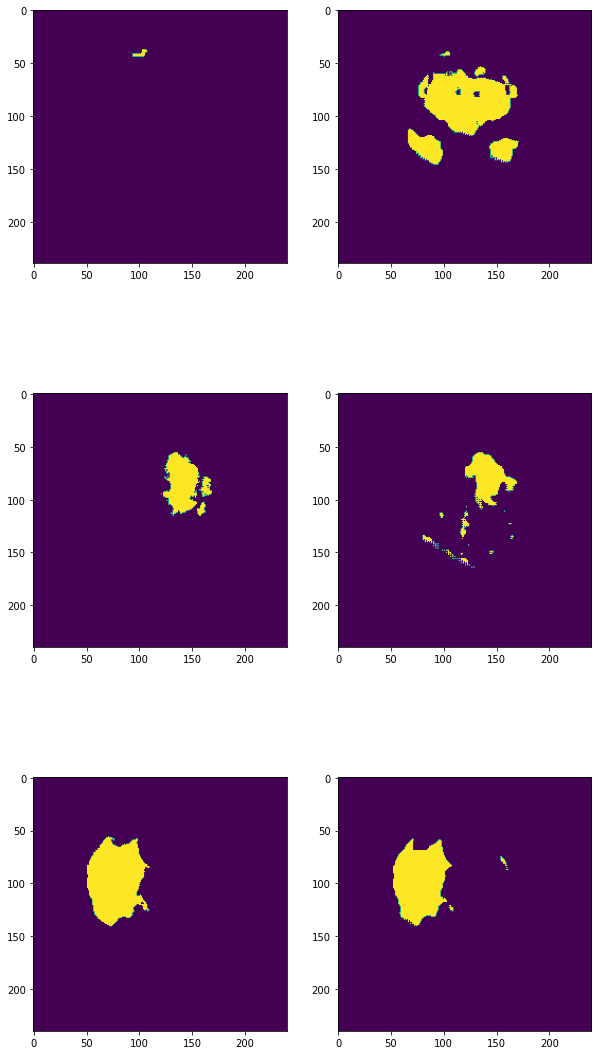

In [69]:
def one(idx):
  with torch.no_grad():
    X, y = dctx[idx]
    X = X.unsqueeze(0).float().to(ctx.device)
    y = y.float().clamp(0., 1.)
    y_hat_sig = torch.sigmoid(ctx.net(X)) > 0.5
    y_hat = y_hat_sig.cpu().reshape(240, 240)
  return y_hat, y

def show(indices):
  f, axarr = plt.subplots(len(indices), 2)
  for i, idx in enumerate(indices):
    y_hat, y = one(idx)
    axarr[i, 0].imshow(y)
    axarr[i, 1].imshow(y_hat)


plt.rcParams["figure.figsize"] = 10,20
show_count = 4
show(torch.randperm(len(dctx))[0:show_count-1])

In [ ]:
ctx.export_onnx("net5.onnx")